# MIRI LRS Slit Spectroscopy: Spectral Extraction

### Author, Date

Sarah Kendrew, ESA and STScI MIRI Branch, sarah.kendrew@esa.int</br>
March 2023


### <span style="color:red">Tl;dr?</span>

<span style="color:red">**Want pretty spectra, don't want to read all the words? Grab the abbreviated version of this notebook in script form, lrs_slit_extraction_fix.py**. 
</span>


### Spectral extraction issues

The automated spectra extraction in the JWST calibration pipeline is very sensitive to coordinate inaccuracies, and as a result, the extract (``x1d``) products in MAST are often of poor quality. Specifically, the ``extract_1d`` step does not reliably place the extraction aperture in the correct place on the array. The algorithm uses the target coordinates in the metadata and the WCS information to place the aperture at the location of the target; the algorithm itself is actually very effective, but as it relies on accurate coordinate information both in the header and in the data WCS information, it is very sensitive to coordinate registration issues. Reasons for such coordinate issues are e.g.:

* inaccuracies in the guide star coordinates that cause the RA, Dec registration of the field to be ofset
* coordinate tarnsformation inaccuracies when resampling
* target coordinate errors

We are actively working on resolving these issues, and in the mean time are updating the specral extraction process to extract based on detector position rather than WCS location. 

**In this notebook we will demo how to perform a more accurate extraction manually using the JWST pipeline, for LEVEL 3 data**. 


### Aims

This notebook will demonstrate how to get a well-calibrated and extracted spectrum from a Low-Resolution Spectroscopy (LRS) observation of a point source in the slit. We have chosen as example data an observation where the extracted products in MAST are affected by the above issues, and don't look right. 

We are actively working on improving the robustness of the spectral extraction algorithms. In the mean time, this notebook provides a template for how to work around the extraction issues and produce clean, well-extracted spectra. We will provide additional explanation along the way. 


### Assumptions

We will start from the Level 2a data. This is the file ending in ``rate.fits``. This data product has undergone basic detector calibration. The units are DN/s. 

The calibration steps assume the target is an unresolved point source, and that the observation used the ALONG SLIT NOD dither pattern. 

**The custom extraction is applied at the Level 3 stage of the pipeline. We include the Spec2Pipeline to provide some extra info & context, but you can also jump in just for the Spec3Pipeline.**


### Test data

The data used in this notebook is an observation of the Type Ia supernova SN2021aefx, observed by Jha et al in PID 2072 (Obs 1), **where the automated spectral extraction failed**. These data were taken with zero exclusive access period, and published in [Kwok et al 2023](https://ui.adsabs.harvard.edu/abs/2023ApJ...944L...3K/abstract). You can retrieve the data from [this Box folder](https://stsci.box.com/s/i2xi18jziu1iawpkom0z2r94kvf9n9kb), and we recommend you place the files in the ``data/`` folder of this repository, or change the directory settings in the notebook prior to running. 

You can of course just use your own data instead of the demo data. 



In [1]:
%matplotlib inline
from glob import glob

import numpy as np
import matplotlib.pyplot as plt

from jwst.pipeline import Spec2Pipeline, Spec3Pipeline
from jwst import datamodels

Let's start by plotting the default Level 3 extracted output file that can be retrieved from MAST. We restrict the short-wavelength end of the x-axis to 5 micron, as our calibration is very poor below this wavelength. **This is not the spectrum we are expecting**. 

2023-03-13 08:46:57,689 - stpipe - WARNING - /var/folders/9l/lthyqbnd6md29c4bpkgdp_980001p3/T/ipykernel_69300/3815960846.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()



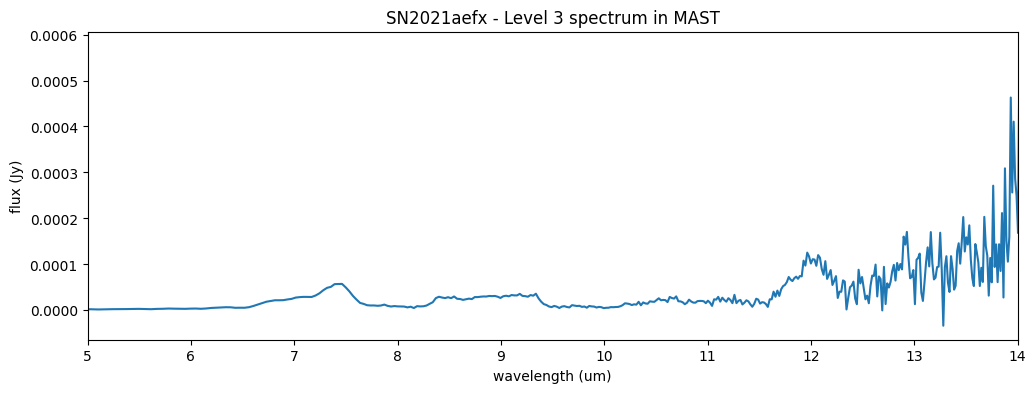

In [2]:
l3_file = 'data/jw02072-o001_t010_miri_p750l_x1d.fits'
l3_spec = datamodels.open(l3_file)

fig, ax = plt.subplots(figsize=[12,4])
ax.plot(l3_spec.spec[0].spec_table['WAVELENGTH'], l3_spec.spec[0].spec_table['FLUX'])
ax.set_xlabel('wavelength (um)')
ax.set_ylabel('flux (Jy)')
ax.set_title('SN2021aefx - Level 3 spectrum in MAST')
ax.set_xlim(5., 14.)
fig.show()


## Spec2Pipeline

The sequence of steps for the LRS slit mode in the Spec2Pipeline is as follows:

* ``assign_wcs``: assigns the world coordinate system extension as well as the wavelength calibration
* ``background``: performs background subtraction
* ``source_type``: assigns a source type. This is inherited from APT, or if not marked in APT as unknown, it will take a pre-selected default value. For MIRI LRS the default value is ``point``. 
* ``flat_field``: divides the science data by the flat field
* ``pathloss``: corrects for wavelength-dependent flux loss due to the truncation by the slit
* ``photom``: converts DN/s pixel values to MJy/sr physical flux densities
* ``extract_1d``: performs spectral extraction. At this stage of the pipeline, the extraction is performed on each nod file separately; these are not yet the _final_ extracted products. 



### Association vs. single file input

A single ``rate`` file can be passed to this pipeline stage or any of its individual steps, and be processed successfully. However, for our default use case of a point source observation using the ALONG SLIT NOD pattern, the input to the Spec2Pipeline is an **association file**, which contains information for both files. The pipeline builds such files for all cases where multiple files need to be combined for pipeline execution. In the case of LRS slit observations, the ``background`` step performs a mutual subtraction of the nods. 

The association files used can also be downloaded from MAST. We demonstrate here how to build them from scratch using the tools provided in the pipeline package. You can read more about associations [here](https://jwst-pipeline.readthedocs.io/en/latest/jwst/associations/level2_asn_technical.html).


In [3]:
from jwst.associations.asn_from_list import asn_from_list
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase

In [4]:
nod1_file = 'data/jw02072001001_06101_00001_mirimage_rate.fits'
nod2_file = 'data/jw02072001001_06101_00002_mirimage_rate.fits'

nods_list = [nod1_file, nod2_file]

In [5]:
asn = asn_from_list(nods_list, rule=DMSLevel2bBase, meta={'program':'02072', 'target':'sn2021aefx', 'asn_pool':'None'})
print(asn)

Association jw02072-o999_none_00002_asn
    Parameters:        Product type: indetermined        Rule:         indetermined        Program:      indetermined        Target:       indetermined        Pool:         indetermined
        
	data/jw02072001001_06101_00001_mirimage with 1 members
	data/jw02072001001_06101_00002_mirimage with 1 members




This association now contains 2 _members_. We will provide each member exposure with its associated background, i.e. the opposite nod file, and write the association to file. 

In [6]:
asn['products'][0]['name'] = nod1_file.split('/')[-1]
asn['products'][1]['name'] = nod2_file.split('/')[-1]
asn['products'][0]['members'].append({'expname': nod2_file, 'exptype':'background'})
asn['products'][1]['members'].append({'expname': nod1_file, 'exptype':'background'})

print(asn)

# write this out to a json file
with open('lrs_slit_test_spec2asn.json', 'w') as fp:
    fp.write(asn.dump()[1])

2023-03-13 08:47:43,137 - stpipe - WARNING - /Users/skendrew/anaconda3/envs/jwst1.9.4/lib/python3.10/site-packages/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
  warnings.warn(err_str, UserWarning)



Association jw02072-o999_none_00002_asn
    Parameters:        Product type: indetermined        Rule:         indetermined        Program:      indetermined        Target:       indetermined        Pool:         indetermined
        
	jw02072001001_06101_00001_mirimage_rate.fits with 2 members
	jw02072001001_06101_00002_mirimage_rate.fits with 2 members




### Running the Spec2Pipeline


We set up and run the Spec2Pipeline, using the association file as input. 

In [7]:
spec2 = Spec2Pipeline()
spec2.save_results = True
spec2.output_dir = 'data/'

sp2_out = spec2.run('lrs_slit_test_spec2asn.json')

2023-03-13 08:47:48,308 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2023-03-13 08:47:48,309 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-03-13 08:47:48,311 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2023-03-13 08:47:48,313 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2023-03-13 08:47:48,314 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2023-03-13 08:47:48,316 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2023-03-13 08:47:48,320 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.
2023-03-13 08:47:48,322 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.
2023-03-13 08:47:48,323 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.
2023-03-13 08:47:48,324 - stpipe.Spec2Pipeline.

2023-03-13 08:47:48,482 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw02072001001_06101_00001_mirimage_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap', 'wfssbkg']
2023-03-13 08:47:49,045 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/skendrew//crds_cache/references/jwst/miri/jwst_miri_apcorr_0007.fits'.
2023-03-13 08:47:49,045 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-03-13 08:47:49,045 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2023-03-13 08:47:49,046 - stpipe.Spec2Pipeline - INFO - Pref

2023-03-13 08:47:49,657 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('data/jw02072001001_06101_00002_mirimage_rate.fits', []).
2023-03-13 08:47:49,658 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'imprint_subtract', 'search_output_file': True, 'input_dir': ''}
2023-03-13 08:47:49,659 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2023-03-13 08:47:49,659 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2023-03-13 08:47:49,712 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<ImageModel(1024, 1032) from jw02072001001_06101_00001_mirimage_rate.fits>, ['data/jw02072001001_06101_00002_mirimage_rate.fits']).
2023-03-13 08:47:49,713 - s

2023-03-13 08:47:51,006 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /Users/skendrew//crds_cache/references/jwst/miri/jwst_miri_photom_0085.fits
2023-03-13 08:47:51,006 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A
2023-03-13 08:47:51,096 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI
2023-03-13 08:47:51,097 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIMAGE
2023-03-13 08:47:51,097 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_LRS-FIXEDSLIT
2023-03-13 08:47:51,098 - stpipe.Spec2Pipeline.photom - INFO -  filter: P750L
2023-03-13 08:47:51,121 - stpipe.Spec2Pipeline.photom - INFO -  subarray: FULL
2023-03-13 08:47:51,122 - stpipe.Spec2Pipeline.photom - INFO - PHOTMJSR value: 13.7913
2023-03-13 08:47:51,167 - stpipe.Spec2Pipeline.photom - INFO - Step photom done
2023-03-13 08:47:51,219 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<ImageModel(1024, 1032) from jw0207200100

2023-03-13 08:47:53,934 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  64.972219630 -54.948504548 64.972219630 -54.947126724 64.972786557 -54.947126724 64.972786557 -54.948504548
2023-03-13 08:47:53,935 - stpipe.Spec2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  64.972219630 -54.948504548 64.972219630 -54.947126724 64.972786557 -54.947126724 64.972786557 -54.948504548
2023-03-13 08:47:53,935 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2023-03-13 08:47:53,946 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done
2023-03-13 08:47:54,006 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<ImageModel(1024, 1032) from jw02072001001_06101_00002_mirimage_rate.fits>, []).
2023-03-13 08:47:54,006 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext':

2023-03-13 08:47:55,148 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done
2023-03-13 08:47:55,204 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<ImageModel(1024, 1032) from jw02072001001_06101_00002_mirimage_rate.fits>,).
2023-03-13 08:47:55,205 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'barshadow', 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}
2023-03-13 08:47:55,205 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.
2023-03-13 08:47:55,208 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done
2023-03-13 08:47:55,262 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from jw02072001001_06101_00002_mirimage_rate.fits>,).
2023-0

2023-03-13 08:47:57,681 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_1063.pmap
2023-03-13 08:47:57,681 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_1063.pmap
2023-03-13 08:47:57,909 - stpipe.Spec2Pipeline - INFO - Saved model in data/jw02072001001_06101_00001_mirimage_cal.fits
2023-03-13 08:47:58,120 - stpipe.Spec2Pipeline - INFO - Saved model in data/jw02072001001_06101_00002_mirimage_cal.fits
2023-03-13 08:47:58,120 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


By default, the Spec2Pipeline for LRS slit will return files of types: 
* ``cal.fits``: photometrically calibrated 2D spectral images, FULL array, not rectified (output from the photom step)
* ``s2d.fits``: photometrically calibrated 2D spectral images, cutout, rectified (output from the resample_spec step)
* ``x1d.fits``: 1D extracted spectra for each nod position

Let's take a look at the resampled 2d products, and at the 1D spectra that were extracted from them. **We can already see here that the automated extraction has not worked properly. The two spectra should be near-identical and they are not! Plus the fluxes are very low, when we are expecting a healthy SNR spectrum.**

2023-03-13 08:48:53,658 - stpipe - WARNING - /var/folders/9l/lthyqbnd6md29c4bpkgdp_980001p3/T/ipykernel_69300/671294767.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2a.show()



['data/jw02072001001_06101_00001_mirimage_s2d.fits', 'data/jw02072001001_06101_00002_mirimage_s2d.fits']


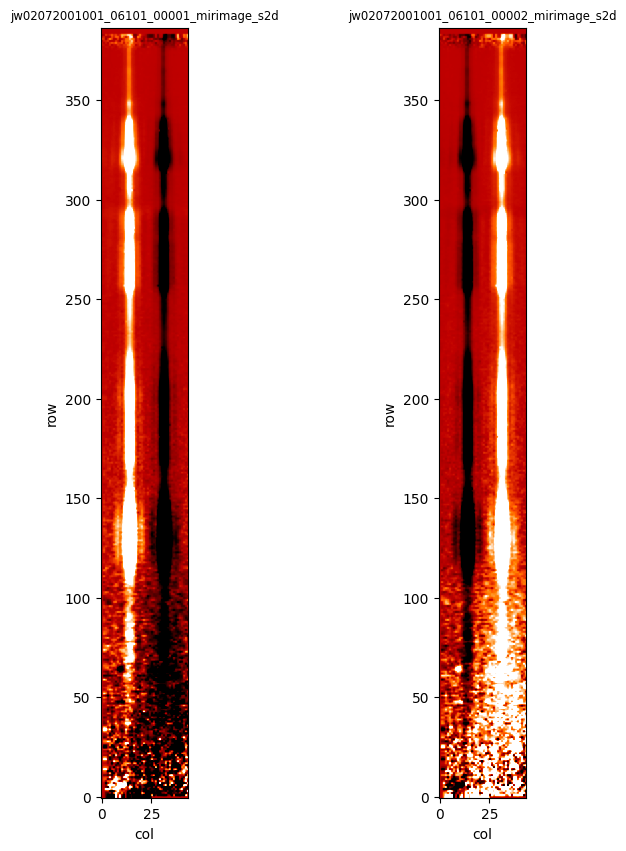

In [8]:
sp2_s2dfiles = glob('data/jw02072*s2d.fits')
#sp2_s2dfiles.reverse()
print(sp2_s2dfiles)

fig2a, ax2a = plt.subplots(ncols=2, figsize=[8,10])
for sdf, ax in zip(sp2_s2dfiles, ax2a):
    im = datamodels.open(sdf)
    ll = (sdf.split('/')[-1]).split('.')[0]
    ax.imshow(im.data, origin='lower', cmap='gist_heat', vmin=-100, vmax=100)
    ax.set_title(ll, fontsize='small')
    ax.set_xlabel('col')
    ax.set_ylabel('row')

fig2a.show()




2023-03-13 08:49:33,355 - stpipe - WARNING - /var/folders/9l/lthyqbnd6md29c4bpkgdp_980001p3/T/ipykernel_69300/2907291018.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2b.show()



['data/jw02072001001_06101_00001_mirimage_x1d.fits', 'data/jw02072001001_06101_00002_mirimage_x1d.fits']


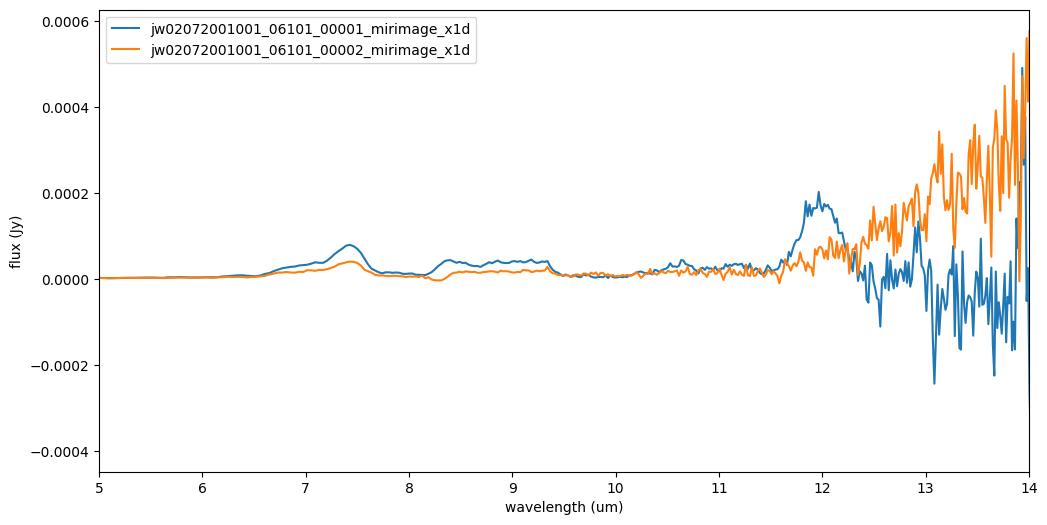

In [10]:
sp2_x1dfiles = glob('data/jw02072001*x1d.fits')
print(sp2_x1dfiles)
fig2b, ax2b = plt.subplots(figsize=[12,6])
for spf in sp2_x1dfiles:
    sp = datamodels.open(spf)
    ll = (spf.split('/')[-1]).split('.')[0]
    ax2b.plot(sp.spec[0].spec_table['WAVELENGTH'], sp.spec[0].spec_table['FLUX'], label=ll)
    
#ax2.plot(l3_spec.spec[0].spec_table['WAVELENGTH'], l3_spec.spec[0].spec_table['FLUX'], 'r-', label='default L3 spectrum')
ax2b.legend()
ax2b.set_xlabel('wavelength (um)')
ax2b.set_ylabel('flux (Jy)')
ax2b.set_xlim(5., 14.)
fig2b.show()

### Note 
The extracted products at Level 2 of the pipeline are not yet "final". They are more affected by bad pixels and detector artifacts than the final Level 3 product. They are useful for quick-look purposes or to diagnose problems, but for full science-ready spectra, you should perform the Level 3 processing. 

**The spectra we see from Level 2 are a sign that there is some coordinate issue that is preventing the automated extraction from working. In the next step we will perform the Spec3Pipeline processing and fix this issue to get a science-ready spectrum**

# Spec3Pipeline

The Level 3 pipeline combines the 2 nod images, which reduces the impact of bad pixels and provides better signal to noise; and performs the final "science-ready" extraction. Whereas the Spec2Pipeline can take both single files and associations as input, the Spec3Pipeline always requires an association as input. 

In the code below we repeat the association creation, and run the Spec3Pipeline. To ensure that the extraction aperture is placed in the correct position, we use a custom extraction reference file, ``miri_lrs_demo_extract1d.json``, that forces the pipeline to extract specific columns. You can adapt this reference file for your own science, definining custom extraction apertures and extraction limits. The file can also be used to specify:

- tapered column extraction (with linear or polynomial-shaped edges)
- background subtraction from an off-target portion of the array


and more. For full details of all the options for this reference file, see the [documentation pages](https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d/reference_files.html#extract1d-reference-file). 

In [11]:
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base

In [12]:
asn3 = asn_from_list(sp2_s2dfiles, rule=DMS_Level3_Base, product_name='PID2072_Obs1_LRS_demo', meta={'program':'02072', 'target':'sn2021aefx', 'asn_pool':'None'})

with open('lrs_slit_test_spec3asn.json', 'w') as fp:
    fp.write(asn3.dump()[1])


2023-03-13 08:49:48,797 - stpipe - WARNING - /Users/skendrew/anaconda3/envs/jwst1.9.4/lib/python3.10/site-packages/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
  warnings.warn(err_str, UserWarning)



In [13]:
spec3 = Spec3Pipeline()
spec3.save_results = True
spec3.output_dir = 'data/'
spec3.extract_1d.override_extract1d = 'miri_lrs_demo_extract1d.json'
spec3.extract_1d.use_source_posn = False

sp3 = spec3.run('lrs_slit_test_spec3asn.json')

2023-03-13 08:50:02,980 - stpipe.Spec3Pipeline - INFO - Spec3Pipeline instance created.
2023-03-13 08:50:02,981 - stpipe.Spec3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2023-03-13 08:50:02,983 - stpipe.Spec3Pipeline.master_background - INFO - MasterBackgroundStep instance created.
2023-03-13 08:50:02,984 - stpipe.Spec3Pipeline.mrs_imatch - INFO - MRSIMatchStep instance created.
2023-03-13 08:50:02,986 - stpipe.Spec3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2023-03-13 08:50:02,987 - stpipe.Spec3Pipeline.resample_spec - INFO - ResampleSpecStep instance created.
2023-03-13 08:50:02,989 - stpipe.Spec3Pipeline.cube_build - INFO - CubeBuildStep instance created.
2023-03-13 08:50:02,991 - stpipe.Spec3Pipeline.extract_1d - INFO - Extract1dStep instance created.
2023-03-13 08:50:02,992 - stpipe.Spec3Pipeline.photom - INFO - PhotomStep instance created.
2023-03-13 08:50:02,993 - stpipe.Spec3Pipeline.combine_1d - INFO - Combine1dStep instance

2023-03-13 08:50:03,390 - stpipe.Spec3Pipeline.outlier_detection - INFO - Performing outlier detection on 2 inputs
2023-03-13 08:50:03,546 - stpipe.Spec3Pipeline.outlier_detection - INFO - Driz parameter kernal: square
2023-03-13 08:50:03,547 - stpipe.Spec3Pipeline.outlier_detection - INFO - Driz parameter pixfrac: 1.0
2023-03-13 08:50:03,547 - stpipe.Spec3Pipeline.outlier_detection - INFO - Driz parameter fillval: INDEF
2023-03-13 08:50:03,547 - stpipe.Spec3Pipeline.outlier_detection - INFO - Driz parameter weight_type: ivm
2023-03-13 08:50:03,637 - stpipe.Spec3Pipeline.outlier_detection - INFO - 1 exposures to drizzle together
2023-03-13 08:50:03,683 - stpipe.Spec3Pipeline.outlier_detection - INFO - Drizzling (387, 44) --> (388, 61)
2023-03-13 08:50:03,774 - stpipe.Spec3Pipeline.outlier_detection - INFO - Exposure jw02072001001_06101_00001_mirimage_outlier_i2d.fits saved to file
2023-03-13 08:50:03,779 - stpipe.Spec3Pipeline.outlier_detection - INFO - 1 exposures to drizzle together


2023-03-13 08:50:16,608 - stpipe - WARNING - /var/folders/9l/lthyqbnd6md29c4bpkgdp_980001p3/T/ipykernel_69300/248178604.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig3a.show()



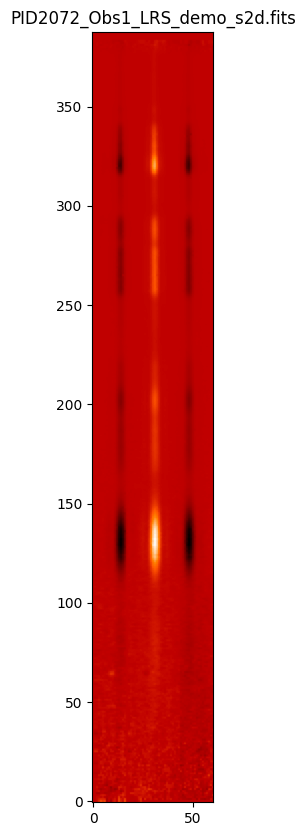

In [14]:
sp3_s2dfiles = glob('data/PID2072*s2d.fits')

fig3a, ax3a = plt.subplots(figsize=[4,10])
im = datamodels.open(sp3_s2dfiles[0])
ax3a.imshow(im.data, origin='lower', cmap='gist_heat')
ax3a.set_title(sp3_s2dfiles[0].split('/')[-1])
fig3a.show()
    

2023-03-13 08:50:25,953 - stpipe - WARNING - /var/folders/9l/lthyqbnd6md29c4bpkgdp_980001p3/T/ipykernel_69300/3219729799.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig3b.show()



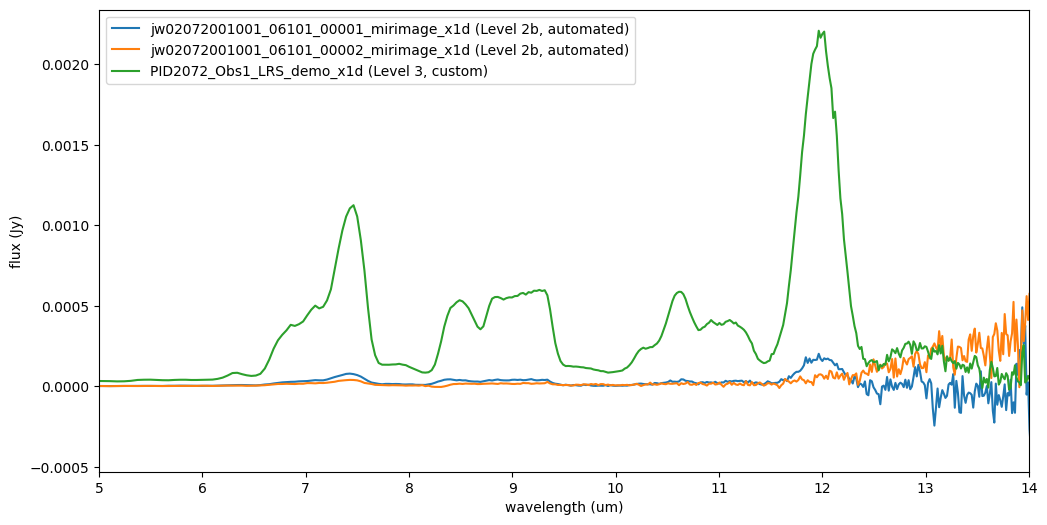

In [15]:
sp3_x1dfile = 'data/PID2072_Obs1_LRS_demo_x1d.fits'


fig3b, ax3b = plt.subplots(figsize=[12,6])

for spf in sp2_x1dfiles:
    sp = datamodels.open(spf)
    ll = (spf.split('/')[-1]).split('.')[0] + ' (Level 2b, automated)'
    ax3b.plot(sp.spec[0].spec_table['WAVELENGTH'], sp.spec[0].spec_table['FLUX'], label=ll)
    
sp3_x1d = datamodels.open(sp3_x1dfile)
ll3 = (sp3_x1dfile.split('/')[-1]).split('.')[0] + ' (Level 3, custom)'
ax3b.plot(sp3_x1d.spec[0].spec_table['WAVELENGTH'], sp3_x1d.spec[0].spec_table['FLUX'], label=ll3)

ax3b.legend()
ax3b.set_xlabel('wavelength (um)')
ax3b.set_ylabel('flux (Jy)')
ax3b.set_xlim(5., 14.)
fig3b.show()

By providing the xstart and xstop limits for the spectral extraction in the custom reference file, and setting the ``use_source_posn`` to False, we prevent the pipeline from using coordinates to place the apertue and instead force it to use our column limits. As a result we get a much cleaner spectrum. 

**Note**: a custom reference file can be provided for the spectral extraction in the Spec2Pipeline, exactly as we did for the Spec3Pipeline run. However this requires the ``extract_1d`` step to be run for each nod file individually, with a custom reference file adjusted to the position of the nod in the field. 

#### Please contact the [JWST Helpdesk](https://stsci.service-now.com/jwst) if you have any questions or problems!

-- END

SK, March 10th 2023